In [1]:
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

In [2]:
import pandas as pd
class StringConverter(dict):

    def __contains__(self, item):

        return True

    def __getitem__(self, item):

        return str

    def get(self, default=None):

        return str

def load_data(data_path = "/Users/vishali/Desktop/SPRING 2021/project-ml"):
    csv_path = os.path.join(data_path, "topcleandata.csv")
    return pd.read_csv(csv_path, low_memory = False)

In [4]:
new = load_data()

In [5]:
new = new.dropna(subset=['ha57'])

In [6]:
new['ha57'] = pd.Categorical(new.ha57)
y = new['ha57']
X = new.drop(['ha57', 'hc11','DHSCC', 'DHSCLUST'], axis = 1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

[0.02716129 0.0701349  0.03063945 0.00792304 0.03392081 0.00708026
 0.00187802 0.02589834 0.01026254 0.00151873 0.01537945 0.02044931
 0.02278226 0.0545124  0.00046202 0.02023646 0.01528682 0.02730013
 0.02743102 0.02649963 0.0279871  0.03021893 0.05285952 0.01296001
 0.01042349 0.01229775 0.01258366 0.01646355 0.01104051 0.01389834
 0.00040669 0.01330112 0.01185519 0.01363259 0.00999837 0.01413158
 0.02363744 0.01994041 0.01830991 0.01896707 0.01913734 0.02012039
 0.01214419 0.02090373 0.01515657 0.01406065 0.0141016  0.00750109
 0.01676262 0.01229435 0.01286348 0.01387604 0.01232179 0.01708604]


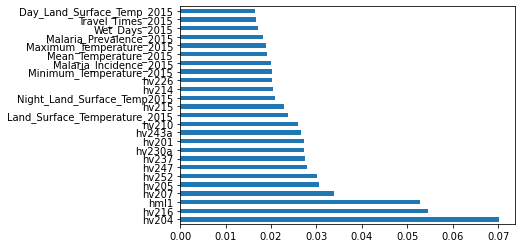

In [9]:
# plot for Feature Importance
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh')

In [10]:
# feature selection
def select_features(X_train, y_train, X_test):
	# configure to select a subset of features
	fs = SelectFromModel(ExtraTreesClassifier(n_estimators=200), max_features=20)
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

In [14]:
# normal logistic with all data
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression( solver = 'liblinear', random_state = 42)
lr.fit(X_train,y_train)
y_pred_LR = lr.predict(X_test)


In [16]:
CM = confusion_matrix(y_test, y_pred_LR)
print(confusion_matrix(y_test, y_pred_LR))
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
FNR = FN / (TP + FN)
print(FNR)
accuracy = accuracy_score(y_test, y_pred_LR)
print('Accuracy: %.2f' % (accuracy*100))

[[1585   99]
 [ 776  109]]
0.8768361581920904
Accuracy: 65.94


In [18]:
# model with FS
# fit the model
model = LogisticRegression(solver='liblinear')
model.fit(X_train_fs, y_train)
# evaluate the model
yhat = model.predict(X_test_fs)
# evaluate predictions
CM = confusion_matrix(y_test, yhat)
print(confusion_matrix(y_test, yhat))
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
FNR = FN / (TP + FN)
print(FNR)
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))

[[1435  249]
 [ 604  281]]
0.6824858757062147
Accuracy: 66.80


In [20]:
# grid search CV
# define models and parameters
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
model = LogisticRegression()
solvers = ['liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=1, cv=cv, scoring='recall',error_score=0)
grid_result = grid_search.fit(X, y)

In [21]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.158154 using {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.155340 (0.027330) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.158154 (0.029733) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.152005 (0.020080) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.158073 (0.029830) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.157114 (0.025303) with: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}


In [23]:
# best c is 10. 
from sklearn.linear_model import LogisticRegression
lr_2 = LogisticRegression(C = 10, solver = 'liblinear', random_state = 42)
lr_2.fit(X_train,y_train)
y_pred_val = lr_2.predict(X_val)

In [25]:
CM = confusion_matrix(y_val, y_pred_val)
print(confusion_matrix(y_val, y_pred_val))
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
FNR = FN / (TP + FN)
print(FNR)
accuracy = accuracy_score(y_val, y_pred_val)
print('Accuracy: %.2f' % (accuracy*100))

[[1559   92]
 [ 820   97]]
0.8942202835332607
Accuracy: 64.49


In [26]:
from sklearn.linear_model import LogisticRegression
lr_2 = LogisticRegression(C = 10, solver = 'liblinear', random_state = 42)
lr_2.fit(X_train_fs,y_train)
y_pred_val_fs = lr_2.predict(X_test_fs)

In [27]:
CM = confusion_matrix(y_test, y_pred_val_fs)
print(confusion_matrix(y_test, y_pred_val_fs))
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
FNR = FN / (TP + FN)
print(FNR)
accuracy = accuracy_score(y_test, y_pred_val_fs)
print('Accuracy: %.2f' % (accuracy*100))

[[1436  248]
 [ 602  283]]
0.6802259887005649
Accuracy: 66.91


In [28]:
# Decision Trees
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(random_state = 42)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [29]:
y_pred_DT = classifier.predict(X_test)

In [30]:
CM = confusion_matrix(y_test, y_pred_DT)
print(confusion_matrix(y_test, y_pred_DT))
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
FNR = FN / (TP + FN)
print(FNR)
accuracy = accuracy_score(y_test, y_pred_DT)
print('Accuracy: %.2f' % (accuracy*100))

[[1192  492]
 [ 492  393]]
0.5559322033898305
Accuracy: 61.70


In [31]:
classifier_fs = DecisionTreeClassifier(random_state = 42)
classifier_fs.fit(X_train_fs, y_train)
y_pred_DT2 = classifier_fs.predict(X_test_fs)

In [32]:
CM = confusion_matrix(y_test, y_pred_DT2)
print(confusion_matrix(y_test, y_pred_DT2))
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
FNR = FN / (TP + FN)
print(FNR)
accuracy = accuracy_score(y_test, y_pred_DT2)
print('Accuracy: %.2f' % (accuracy*100))

[[1215  469]
 [ 513  372]]
0.5796610169491525
Accuracy: 61.78


In [ ]:
# Grid search for Decision Trees
from sklearn import tree
from sklearn.model_selection import GridSearchCV
import random
from random import randint
max_depth_range = range(1,10)
min_samples_leaf_range = range(1,10)
parameters = {'criterion': ['gini'], 'max_depth': max_depth_range, 'min_samples_leaf': min_samples_leaf_range}
clf = GridSearchCV(DecisionTreeClassifier(), parameters, n_jobs=4, cv= 5)
clf.fit(X=X, y=y)
tree_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_)

In [33]:
from sklearn.tree import DecisionTreeClassifier
classifier2 = DecisionTreeClassifier(max_depth = 2, min_samples_leaf = 1, random_state = 42)
classifier2.fit(X_train, y_train)
y_pred_val = classifier2.predict(X_val)

In [34]:
CM = confusion_matrix(y_val, y_pred_val)
print(confusion_matrix(y_val, y_pred_val))
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
FNR = FN / (TP + FN)
print(FNR)
accuracy = accuracy_score(y_val, y_pred_val)
print('Accuracy: %.2f' % (accuracy*100))

[[1184  467]
 [ 377  540]]
0.411123227917121
Accuracy: 67.13


In [36]:
from sklearn.tree import DecisionTreeClassifier
classifier2 = DecisionTreeClassifier(max_depth = 2, min_samples_leaf = 1, random_state = 42)
classifier2.fit(X_train_fs, y_train)
y_pred_fs2 = classifier2.predict(X_test_fs)

In [39]:
CM = confusion_matrix(y_test, y_pred_fs2)
print(confusion_matrix(y_test, y_pred_fs2))
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
FNR = FN / (TP + FN)
print(FNR)
accuracy = accuracy_score(y_test, y_pred_fs2)
print('Accuracy: %.2f' % (accuracy*100))

[[1660   24]
 [ 861   24]]
0.9728813559322034
Accuracy: 65.55


In [40]:

# random forests
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()    

In [41]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X, y)
y_rf = clf.predict(X_test)
CM = confusion_matrix(y_test, y_rf)
print(confusion_matrix(y_test, y_rf))
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
FNR = FN / (TP + FN)
print(FNR)
accuracy = accuracy_score(y_test, y_rf)
print('Accuracy: %.2f' % (accuracy*100))

[[1512  172]
 [ 636  249]]
0.7186440677966102
Accuracy: 68.55


In [43]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train_fs, y_train)
y_rf = clf.predict(X_test_fs)
CM = confusion_matrix(y_test, y_rf)
print(confusion_matrix(y_test, y_rf))
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
FNR = FN / (TP + FN)
print(FNR)
accuracy = accuracy_score(y_test, y_rf)
print('Accuracy: %.2f' % (accuracy*100))

[[1604   80]
 [ 788   97]]
0.8903954802259887
Accuracy: 66.21


In [55]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled_fs = scaler.fit_transform(X_train_fs)
X_test_scaled_fs = scaler.transform(X_test_fs)


from sklearn.svm import SVC

lin_svc = SVC(max_iter=100000,random_state=42)
lin_svc.fit(X_train_scaled, y_train)
y_pred = lin_svc.predict(X_test_scaled)
CM = confusion_matrix(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
FNR = FN / (TP + FN)
print(FNR)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %.2f' % (accuracy*100))


[[1383  301]
 [ 527  358]]
0.5954802259887005
Accuracy: 67.77


In [52]:
# 'gamma': 'scale', 'kernel': 'sigmoid'}
from sklearn.svm import SVC
lin_svc = SVC(max_iter=100000,C = 50, gamma='scale', kernel='sigmoid', random_state=42)
lin_svc.fit(X_train_scaled_fs, y_train)
y_pred_fs = lin_svc.predict(X_test_scaled_fs)

In [54]:
CM = confusion_matrix(y_test, y_pred_fs)
print(confusion_matrix(y_test, y_pred_fs))
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
FNR = FN / (TP + FN)
print(FNR)
accuracy = accuracy_score(y_test, y_pred_fs)
print('Accuracy: %.2f' % (accuracy*100))

[[1151  533]
 [ 514  371]]
0.5807909604519774
Accuracy: 59.24
